In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

┌ Info: Precompiling QControl [edd81335-bcb3-4e33-9681-20bc820459a6]
└ @ Base loading.jl:1423


In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

In [6]:
using PyCall;
# only needed once
# using Conda;
# Conda.add("qutip");
# Conda.add("imageio");

# Playground

TODOs
- [ ] multiply by tanh rise and fall at beginning and end of pulse, 10ns
- [ ] look into why longer times are not working rn
- [ ] implement stricter amplitude constraint (maybe through parameterized pulse?)
- [ ] add population constraint
- [ ] figure out how to add linear constraints, if needed

# Single Qubit System

In [8]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*.01*dm(spinup(bq_single))
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [-spinup(bq_single)]
;

In [9]:
# # Base Dynamics
# tf = 1.0 #ns
# tspan = [0.0:0.01:tf;]
# psi0 = normalize(spinup(bq_single)*.25 + spindown(bq_single)*.75)

# # Dynamic function
# function Ht(t,psi)
#     return H₀_single
# end

# tout, psi_t = timeevolution.schroedinger_dynamic(tspan, psi0, Ht);

In [10]:
# animate_bloch(psi_t, duration=0.03, save_all=true)

# Set up Dynamics

In [87]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [88]:
model = QC.QuantumState();

In [89]:
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 20.0 # ns, total time
dt = tf / (N-1) # time step

obj = gen_default_objective(state_dim, control_dim, ψt_state; N=N, tf=tf, R_scale=0.0001)

Objective

In [138]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)

# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

In [139]:
bnd = BoundConstraint(state_dim,control_dim, u_min=fill(0,control_dim), u_max=fill(0,control_dim))  # make it the first constraint
add_constraint!(cons, bnd, 1)
add_constraint!(cons, bnd, N-1)
# add_constraint!(cons, bnd, N)

In [140]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model), constraints=cons);

In [141]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [142]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8
opts.max_cost_value = 1e20

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [143]:
solve!(solver);

┌ Warning: A not upper triangular. Creating a new upper-triangular matrix.
└ @ Altro.Cqdldl /Users/phionx/.julia/packages/Altro/jipqO/src/qdldl.jl:156


In [144]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [145]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 36
Final cost: 0.0044863812824262475
Final constraint satisfaction: 3.352145605539647e-8


# Save Data

In [146]:
folder = "data_20220616"

"data_20220616"

In [147]:
# save data (uncomment to save)
save_solver_data(solver, label=string(folder, "/pulse_", Integer(tf), "ns"))

In [148]:
# load data
data = load_solver_data(string(folder, "/pulse_", Integer(tf), "ns.jld2"))

Dict{String, Vector} with 2 entries:
  "U" => SVector{2, Float64}[[0.0, -7.87476e-22], [0.317444, 0.176685], [0.3172…
  "X" => SVector{4, Float64}[[1.0, -4.96318e-19, 3.19588e-19, 2.1684e-19], [0.9…

# Analysis

In [149]:
X = data["X"]    # alternatively states(prob)
U = data["U"]   # alternatively controls(prob)
Ucv = controls_to_amplitudes(U)
Ucv = map(cv -> cv[1], Ucv)
Urv = map(cv -> real(cv), Ucv)
Uiv = map(cv -> imag(cv), Ucv)
Uav = map(cv -> norm(cv), Ucv)
Xqv = states_to_kets(X, bq_single)
;

In [150]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
  1.0 + 0.0im
 -0.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
        -1.0 + 4.412e-14im
 -5.1721e-13 - 1.3935e-13im


In [151]:
# szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);
r1t = map(qv -> real(qv.data[1]), Xqv);
i1t = map(qv -> imag(qv.data[1]), Xqv);
leakaget = map(qv -> abs(qv.data[2]), Xqv);

# Plots

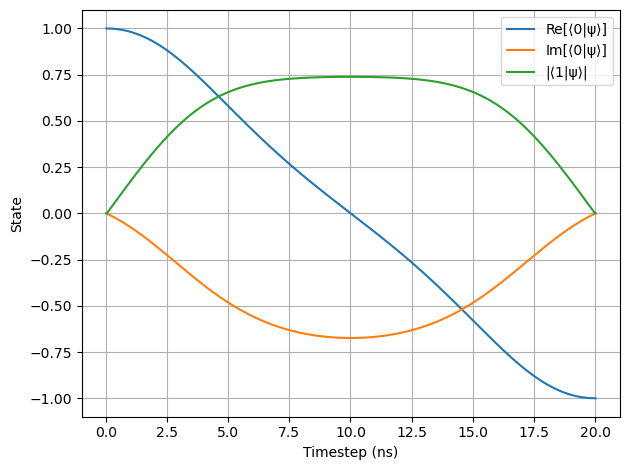

In [152]:
ts = 1:N
plot(dt*ts, r1t, label="Re[⟨0|ψ⟩]")
plot(dt*ts, i1t, label="Im[⟨0|ψ⟩]")
plot(dt*ts, leakaget, label="|⟨1|ψ⟩|")
xlabel("Timestep (ns)")
ylabel("State")
grid("on")
legend()
tight_layout()

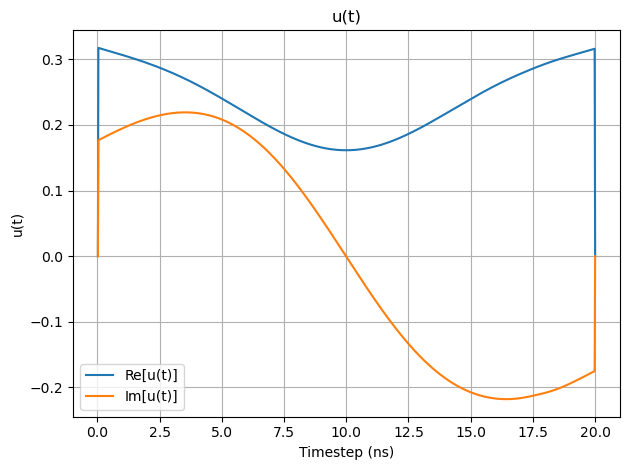

In [153]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

In [47]:
using FFTW

function fft_plot(u, dt, tf; t0 = 0)    
    # using DSP
    Ts = dt # sampling period
    tmax = tf # Start time 
    
    # time coordinate
    t = t0:Ts:tmax

    # real
    ur = map(cv -> real(cv), u)
    ui = map(cv -> imag(cv), u)
    
    signal = ur
    F_r = fft(signal) |> fftshift
    freqs_r = fftfreq(length(t), 1.0/Ts) |> fftshift

    # real
    signal = Uiv
    F_i = fft(signal) |> fftshift
    freqs_i = fftfreq(length(t), 1.0/Ts) |> fftshift

    # plots 
    # time_domain = plot(t, signal)

    freq_domain = plot(freqs_r, abs.(F_r), label="F{Re[u(t)]}")
    freq_domain = plot(freqs_i, abs.(F_i), label="F{Im[u(t)]}")
    xlabel("Frequency [GHz]")
    xlim(-1,1)
    grid("on")
    legend()
    tight_layout()
end

fft_plot (generic function with 1 method)

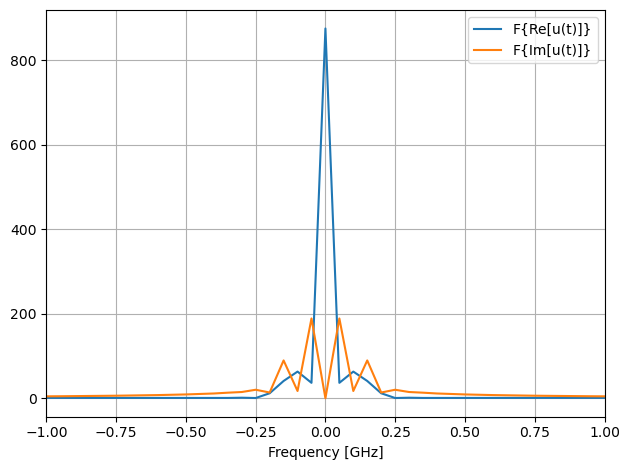

In [49]:
fft_plot(Ucv, dt*N/(N-1), tf; t0 = 0) 

In [249]:
typeof(Ucv)

Vector{ComplexF64} (alias for Array{Complex{Float64}, 1})

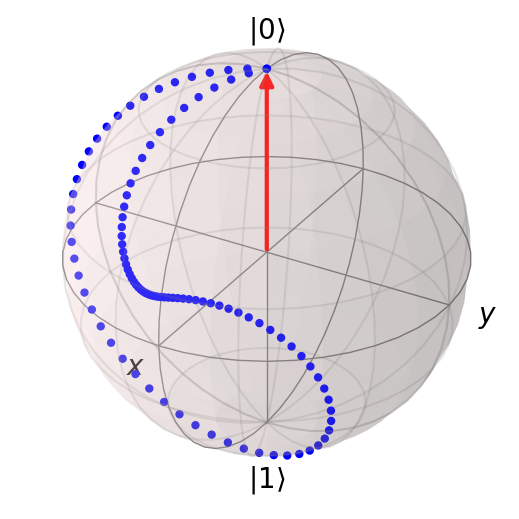

PyObject <qutip.bloch.Bloch object at 0x1d4c21310>

In [188]:
animate_bloch(Xqv[1:10:end], duration=0.03, save_all=true)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)